In [1]:
import requests
import os
import json
import pandas as pd
import time
import codecs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import random

In [3]:
os.chdir('Documents/20221127_china_city_tweets/')

In [4]:
tweets = pd.DataFrame()

In [5]:
list1 = [x for x in os.listdir() if "without_retweets" in x]

In [6]:
list1

['2022-11-28_beishangguang_tweets_without_retweets_2022-11-21T170300Z_2022-11-25T215101Z.csv',
 '2022-11-28_beishangguang_tweets_without_retweets_2022-11-21T190300Z_2022-11-22T154738Z.csv',
 '2022-11-28_beishangguang_tweets_without_retweets_2022-11-21T220300Z_2022-11-22T132521Z.csv',
 '2022-11-29_beishangguang_tweets_without_retweets_2022-11-27T000000Z_2022-11-28T210000Z.csv',
 '2022-11-29_beishangguang_tweets_without_retweets_2022-11-28T210000Z_2022-11-29T140000Z.csv',
 '2022-11-30_beishangguang_tweets_without_retweets_2022-11-29T140000Z_2022-11-30T140000Z.csv',
 '2022-12-02_beishangguang_tweets_without_retweets_2022-11-30T140000Z_2022-12-01T140000Z.csv']

In [7]:
for path in list1:
    df = pd.read_csv(path, low_memory = False)
    tweets = tweets.append(df)

In [8]:
tweets = tweets.drop('Unnamed: 0', axis = 1)

In [9]:
tweets = tweets.drop_duplicates()

In [10]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3279012 entries, 0 to 261330
Data columns (total 21 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   referenced_tweets       object 
 1   created_at              object 
 2   conversation_id         int64  
 3   reply_settings          object 
 4   author_id               int64  
 5   edit_history_tweet_ids  object 
 6   entities                object 
 7   possibly_sensitive      bool   
 8   lang                    object 
 9   attachments             object 
 10  text                    object 
 11  id                      int64  
 12  source                  object 
 13  context_annotations     object 
 14  in_reply_to_user_id     float64
 15  geo                     object 
 16  withheld                object 
 17  retweet_count           int64  
 18  reply_count             int64  
 19  like_count              int64  
 20  quote_count             int64  
dtypes: bool(1), float64(1), int64(7)

In [11]:
tweets.created_at = [pd.to_datetime(x) for x in tweets.created_at]

In [13]:
tweets.created_at.max()

Timestamp('2022-12-01 13:59:59+0000', tz='UTC')

In [14]:
tweets['date'] = [x.date() for x in tweets.created_at]
tweets['hour'] = [x.hour for x in tweets.created_at]
tweets['date_hour'] = [str(x) + '-' + str(y) for (x,y) in zip(tweets.date, tweets.hour)]

In [15]:
def show_chart(df):
    volbydate = pd.DataFrame(df.groupby('date_hour').created_at.count())
    volbydate = volbydate.sort_values('date_hour')
    volbydate = volbydate.reset_index()
    fig, axs = plt.subplots(1, 1,figsize=(20, 6))
    sns.barplot(volbydate.date_hour, volbydate.created_at, color = 'grey')
    plt.xticks(rotation= 45)

Hourly tweet volume


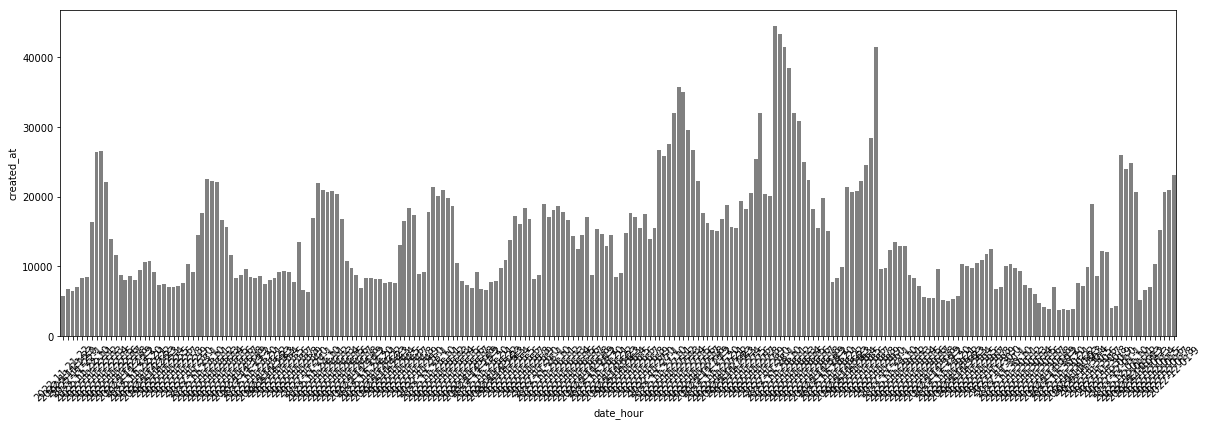

In [16]:
print('Hourly tweet volume')
show_chart(tweets)

how about users?

In [17]:
useriddf = tweets[['date_hour','author_id']].drop_duplicates()

In [18]:
len(useriddf.author_id.unique())

302699

In [19]:
usercount = pd.DataFrame(useriddf.groupby('date_hour').author_id.count())

In [20]:
usercount = usercount.reset_index()

In [21]:
usercount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_hour  232 non-null    object
 1   author_id  232 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


Hourly user count


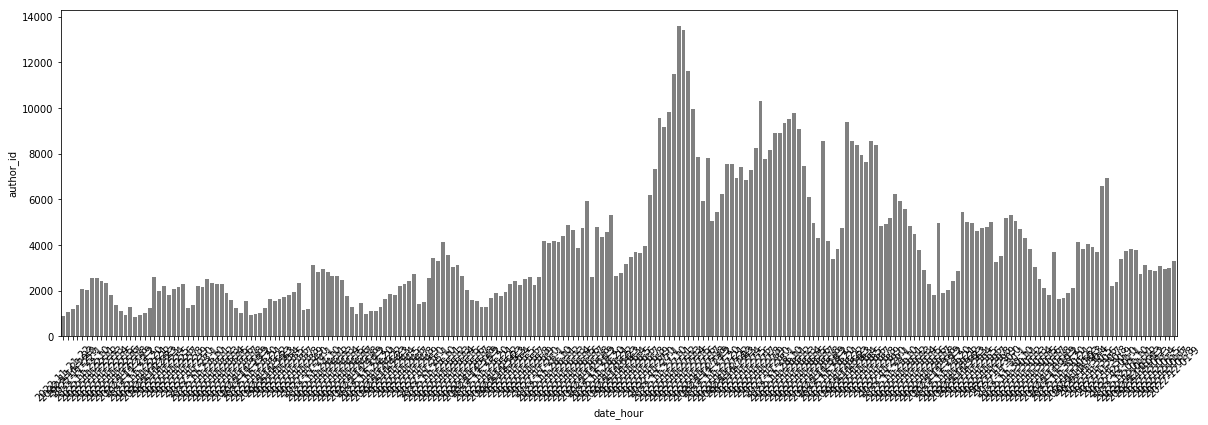

In [22]:
print('Hourly user count')
fig, axs = plt.subplots(1, 1,figsize=(20, 6))
sns.barplot(usercount.date_hour, usercount.author_id, color = 'grey')
plt.xticks(rotation= 45);

We can see that the volume of tweets have risen, but not as dramatically as the volume of users

Taking a sampling of...the tweets? the users? their interaction? Or just using the network graphs?

taking a sampling of users by hour, and if a spammy account posts a lot then we'll see....

In [23]:
userbyhour = pd.DataFrame(useriddf.groupby('date_hour').author_id.unique())

In [24]:
userbyhour.head()

,author_id
date_hour,
2022-11-21-22,"[1144696833588903936, 1572752280381702147, 150..."
2022-11-21-23,"[1156166393798094848, 1316704549374103554, 146..."
2022-11-22-0,"[1531024932884434956, 1087714082055024641, 155..."
2022-11-22-1,"[1519702168378515456, 1539305919661518853, 980..."
2022-11-22-10,"[1421333745794048003, 1260911498198544385, 149..."


In [25]:
userbyhour['idcount'] = [len(x) for x in userbyhour.author_id]

In [26]:
userbyhour[userbyhour.idcount == 13429]

,author_id,idcount
date_hour,,
2022-11-27-15,"[1550364051439755265, 1590368298935402496, 158...",13429


In [27]:
userbyhour.idcount.sort_values()

date_hour
2022-11-22-20      861
2022-11-21-22      897
2022-11-22-21      910
2022-11-23-20      928
2022-11-22-19      928
                 ...  
2022-11-27-9     10325
2022-11-27-13    11476
2022-11-27-16    11623
2022-11-27-15    13429
2022-11-27-14    13617
Name: idcount, Length: 232, dtype: int64

pulling out this slice

next - get a slice of the network and visualize

In [28]:
tweets['ref_type'] = [x.split(',')[0].split(':')[1] if pd.isna(x) == False else x for x in tweets.referenced_tweets ]

In [29]:
tweets['ref_id'] = [x.split(',')[1].split(':')[1] if pd.isna(x) == False else x for x in tweets.referenced_tweets ]

In [30]:
tweets.ref_type = tweets.ref_type.str.replace("'","")

In [31]:
tweets.ref_id = tweets.ref_id.str.replace("'","").str.replace('}','').str.replace(']','')

In [32]:
tweets.id = tweets.id.astype(str)

In [33]:
peaktweets = tweets[(tweets.date_hour == '2022-11-27-14')].copy()

In [34]:
peaktweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35762 entries, 763323 to 799084
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   referenced_tweets       24353 non-null  object             
 1   created_at              35762 non-null  datetime64[ns, UTC]
 2   conversation_id         35762 non-null  int64              
 3   reply_settings          35762 non-null  object             
 4   author_id               35762 non-null  int64              
 5   edit_history_tweet_ids  35762 non-null  object             
 6   entities                35529 non-null  object             
 7   possibly_sensitive      35762 non-null  bool               
 8   lang                    35762 non-null  object             
 9   attachments             26405 non-null  object             
 10  text                    35762 non-null  object             
 11  id                      35762 non-n

In [35]:
beforefire_peaktweets = tweets[(tweets.date_hour == '2022-11-21-22')].copy()

In [36]:
beforefire_peaktweets.text.head()

126293    Quentin MacMillan  #上海  Dale Snow  #上海线下    Su...
126294    全球高端外围预约 VX:jlm222266 QQ:2862735422    ||上海嫩模 ...
126295    torch, illuminating1  0.0D6  #广州 #南京 #苏州 https...
126296    s that you have reache0026#上海 #线下  #上海  #外围 ht...
126297    成都大麻 中国大麻\n品质保证 欢迎咨询\n成都可面 绝对真实\n认准id\n\nhttps...
Name: text, dtype: object

In [37]:
cutoff = pd.to_datetime('2022-11-24T11:50:00Z')

In [38]:
tranche = cutoff - tweets.created_at.min()

In [39]:
cutoff + tranche

Timestamp('2022-11-27 01:37:00+0000', tz='UTC')

In [40]:
cutoff + tranche *2

Timestamp('2022-11-29 15:24:00+0000', tz='UTC')

In [41]:
tweets.created_at.max()

Timestamp('2022-12-01 13:59:59+0000', tz='UTC')

In [42]:
tweetsbyid = pd.DataFrame(tweets.groupby(['author_id','date'])['id'].count())

In [43]:
tweetsbyid.columns = ['tweet_count']

In [44]:
tweetsbyid = tweetsbyid.reset_index()

In [45]:
maybebots = tweetsbyid[tweetsbyid.tweet_count >= 72]

In [46]:
len(maybebots.author_id.unique())

4143

In [47]:
maybebotspv = pd.pivot_table(maybebots, values = 'tweet_count', index = 'author_id', columns = 'date')

In [48]:
maybebotspv = maybebotspv.reset_index()

In [49]:
maybebotspv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   author_id   4143 non-null   int64  
 1   2022-11-21  53 non-null     float64
 2   2022-11-22  626 non-null    float64
 3   2022-11-23  622 non-null    float64
 4   2022-11-24  558 non-null    float64
 5   2022-11-25  637 non-null    float64
 6   2022-11-26  737 non-null    float64
 7   2022-11-27  879 non-null    float64
 8   2022-11-28  1310 non-null   float64
 9   2022-11-29  434 non-null    float64
 10  2022-11-30  245 non-null    float64
 11  2022-12-01  516 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 388.5 KB


In [50]:
maybebotspv.author_id = maybebotspv.author_id.astype(str)

In [52]:
maybebotspv.head()

date,author_id,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30,2022-12-01
0,23749001,NaN,NaN,NaN,NaN,NaN,NaN,145.0,NaN,NaN,NaN,NaN
1,25390452,NaN,NaN,356.0,1315.0,1277.0,567.0,NaN,NaN,NaN,NaN,NaN
2,26617160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,NaN,NaN,NaN
3,41656176,NaN,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN
4,45577593,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN
